# Automated Machine Learning

The flaml library from Microsoft can automate the process of selecting a model and appropriate hyperparameters. 

It is just one of the automated machine learning libraries out there!

First, let's import the flaml library, along with our standard imports for data manipulation and machine learning. 

In [36]:
try:
    from flaml import AutoML
except ModuleNotFoundError:
    !pip install flaml

import pandas as pd
import numpy as np

# Machine learning setup imports
from sklearn.model_selection import train_test_split

# Model imports
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

# Model scoring imports
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, f1_score, precision_score, \
                            recall_score, roc_auc_score

We're going to work with the preprocessed titanic data, splitting it into training, validation and testing datasets.

In [37]:
try:
    data = pd.read_csv("data/processed_data.csv")

except FileNotFoundError:
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'

    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

data = data.astype(float)

# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

X = data.drop('Survived',axis=1) # X = all 'data' except the 'survived' column
y = data['Survived'] # y = 'survived' column from 'data'

feature_names = X.columns.tolist()

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_validate, y_train, y_validate = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training Dataset Samples: {len(X_train)}")
print(f"Validation Dataset Samples: {len(X_validate)}")
print(f"Testing Dataset Samples: {len(X_test)}")

Training Dataset Samples: 569
Validation Dataset Samples: 143
Testing Dataset Samples: 179


## Simple initial auto ML training

Let's try out a simple instance of automated training with flaml. 

We need to pass in training and testing data, tell it what kind of task we're conducting (e.g. classification, regression), how long to keep trying different models (here, we've gone for 60 seconds), and set a random seed for reproducibility. 

In [38]:
automl = AutoML()
automl.fit(X_train, y_train,
           task="classification",
           time_budget=60,
           seed=42)

[flaml.automl.logger: 07-29 23:15:28] {1680} INFO - task = classification
[flaml.automl.logger: 07-29 23:15:28] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-29 23:15:28] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-29 23:15:28] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']


[flaml.automl.logger: 07-29 23:15:28] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-29 23:15:28] {2345} INFO - Estimated sufficient time budget=825s. Estimated necessary time budget=20s.
[flaml.automl.logger: 07-29 23:15:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.1860,	best estimator lgbm's best error=0.1860
[flaml.automl.logger: 07-29 23:15:28] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-29 23:15:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.1614,	best estimator lgbm's best error=0.1614
[flaml.automl.logger: 07-29 23:15:28] {2219} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 07-29 23:15:28] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.1516,	best estimator lgbm's best error=0.1516
[flaml.automl.logger: 07-29 23:15:28] {2219} INFO - iteration 3, current learner lgbm
[flaml.automl.logger: 07-29 23:15:28] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.1468,	best estimator l

We can run this line to see what model it selected.

In [39]:
automl.model

And this will give us the parameters it chose. 

In [40]:
automl.best_config

{'early_stopping_rounds': 10,
 'learning_rate': 0.08181308076296119,
 'n_estimators': 21}

Finally, we can output the best configuration for each of the estimators it tried. 

In [41]:
automl.best_config_per_estimator

{'lgbm': {'n_estimators': 5,
  'num_leaves': 35,
  'min_child_samples': 12,
  'learning_rate': 0.6152167721646307,
  'log_max_bin': 9,
  'colsample_bytree': 0.9236754665076755,
  'reg_alpha': 0.0009765625,
  'reg_lambda': 2.5956586580400387},
 'rf': {'n_estimators': 8,
  'max_features': 0.3522661192428198,
  'max_leaves': 11,
  'criterion': 'gini'},
 'catboost': {'early_stopping_rounds': 10,
  'learning_rate': 0.08181308076296119,
  'n_estimators': 21},
 'xgboost': {'n_estimators': 49,
  'max_leaves': 8,
  'min_child_weight': 1.6432463021924941,
  'learning_rate': 0.1014993900453572,
  'subsample': 0.892732835389516,
  'colsample_bylevel': 1.0,
  'colsample_bytree': 1.0,
  'reg_alpha': 0.26675517308462793,
  'reg_lambda': 0.023187687303412453},
 'extra_tree': {'n_estimators': 9,
  'max_features': 0.21337293465256343,
  'max_leaves': 14,
  'criterion': 'gini'},
 'xgb_limitdepth': {'n_estimators': 9,
  'max_depth': 7,
  'min_child_weight': 1.5981523613778321,
  'learning_rate': 0.4433369

Now let's evaluate this model and put the results into a dataframe.

We can use our `automl` variable where we'd usually use `model`. 

In [42]:
y_pred_train = automl.predict(X_train)
y_pred_val = automl.predict(X_validate)

tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

results_df = pd.DataFrame({
          'Accuracy (training)': np.mean(y_pred_train == y_train),
          'Accuracy (validation)': np.mean(y_pred_val == y_validate),
          'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
          'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
          "AUC": roc_auc_score(y_validate, y_pred_val),
          "Training AUC": roc_auc_score(y_train, y_pred_train),
          "f1": f1_score(y_validate, y_pred_val, average='macro'),
          "Training f1": f1_score(y_train, y_pred_train, average='macro'),
          "FP": fp,
          "FN": fn

          }, index=["Auto ML - Default Parameters - Scoring on ROC AUC"]
).round(3)

results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,Training AUC,f1,Training f1,FP,FN
Auto ML - Default Parameters - Scoring on ROC AUC,0.863,0.811,0.802,0.8,0.8,0.846,0.801,0.851,13,14


This seems like pretty reasonable performance, based on our previous interactions with the titanic dataset, though not as good as we've seen sometimes.

## Customisation

Let's define a function that will allow us to quickly calculate and store metrics when assessing the `automl` library.

In [43]:
def auto_ml_get_results(name):
    y_pred_train = automl.predict(X_train)
    y_pred_val = automl.predict(X_validate)

    tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

    return pd.DataFrame({
            'Accuracy (training)': np.mean(y_pred_train == y_train),
            'Accuracy (validation)': np.mean(y_pred_val == y_validate),
            'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
            'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
            "AUC": roc_auc_score(y_validate, y_pred_val),
            "Training AUC": roc_auc_score(y_train, y_pred_train),
            "f1": f1_score(y_validate, y_pred_val, average='macro'),
            "Training f1": f1_score(y_train, y_pred_train, average='macro'),
            "FP": fp,
            "FN": fn

            }, index=[name]
    ).round(3)


Now let's  try training again, this time asking it to score on a different metric - the f1 score.

In [44]:
automl = AutoML()
automl.fit(X_train, y_train,
           task="classification",
           time_budget=60,
           metric="f1",
           seed=42)
results_df = pd.concat(
    [results_df,
    auto_ml_get_results(name="Auto ML - Scoring on f1")]
)

[flaml.automl.logger: 07-29 23:16:28] {1680} INFO - task = classification
[flaml.automl.logger: 07-29 23:16:28] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-29 23:16:28] {1789} INFO - Minimizing error metric: 1-f1
[flaml.automl.logger: 07-29 23:16:28] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-29 23:16:28] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 07-29 23:16:28] {2345} INFO - Estimated sufficient time budget=505s. Estimated necessary time budget=12s.
[flaml.automl.logger: 07-29 23:16:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.4095,	best estimator lgbm's best error=0.4095
[flaml.automl.logger: 07-29 23:16:28] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-29 23:16:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.4095,	best estimator lgbm's best error=0.4095
[flaml.automl.logger: 07-29 2

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:08] {2392} INFO -  at 40.3s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:08] {2219} INFO - iteration 269, current learner lrl1
[flaml.automl.logger: 07-29 23:17:08] {2392} INFO -  at 40.5s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:08] {2219} INFO - iteration 270, current learner lrl1
[flaml.automl.logger: 07-29 23:17:09] {2392} INFO -  at 40.6s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:09] {2219} INFO - iteration 271, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:09] {2392} INFO -  at 40.8s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:09] {2219} INFO - iteration 272, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:09] {2392} INFO -  at 40.9s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:09] {2219} INFO - iteration 273, current learner lrl1
[flaml.automl.logger: 07-29 23:17:09] {2392} INFO -  at 41.0s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:09] {2219} INFO - iteration 274, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:09] {2392} INFO -  at 41.1s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:09] {2219} INFO - iteration 275, current learner lrl1
[flaml.automl.logger: 07-29 23:17:09] {2392} INFO -  at 41.3s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:09] {2219} INFO - iteration 276, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:09] {2392} INFO -  at 41.4s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:09] {2219} INFO - iteration 277, current learner lrl1
[flaml.automl.logger: 07-29 23:17:10] {2392} INFO -  at 41.5s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:10] {2219} INFO - iteration 278, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:10] {2392} INFO -  at 41.6s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:10] {2219} INFO - iteration 279, current learner lrl1
[flaml.automl.logger: 07-29 23:17:10] {2392} INFO -  at 41.8s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:10] {2219} INFO - iteration 280, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:10] {2392} INFO -  at 41.9s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:10] {2219} INFO - iteration 281, current learner lrl1
[flaml.automl.logger: 07-29 23:17:10] {2392} INFO -  at 42.0s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:10] {2219} INFO - iteration 282, current learner lrl1
[flaml.automl.logger: 07-29 23:17:10] {2392} INFO -  at 42.2s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:10] {2219} INFO - iteration 283, current learner xgboost
[flaml.automl.logger: 07-29 23:17:10] {2392} INFO -  at 42.2s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:10] {2219} INFO - iteration 284, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:10] {2392} INFO -  at 42.4s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:10] {2219} INFO - iteration 285, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:10] {2392} INFO -  at 42.5s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:10] {2219} INFO - iteration 286, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:11] {2392} INFO -  at 42.6s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:11] {2219} INFO - iteration 287, current learner lrl1
[flaml.automl.logger: 07-29 23:17:11] {2392} INFO -  at 42.7s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:11] {2219} INFO - iteration 288, current learner lrl1
[flaml.automl.logger: 07-29 23:17:11] {2392} INFO -  at 42.8s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:11] {2219} INFO - iteration 289, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:11] {2392} INFO -  at 43.0s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:11] {2219} INFO - iteration 290, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:11] {2392} INFO -  at 43.1s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:11] {2219} INFO - iteration 291, current learner extra_tree


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:11] {2392} INFO -  at 43.3s,	estimator extra_tree's best error=0.3095,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:11] {2219} INFO - iteration 292, current learner lrl1
[flaml.automl.logger: 07-29 23:17:11] {2392} INFO -  at 43.5s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:11] {2219} INFO - iteration 293, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:12] {2392} INFO -  at 43.6s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:12] {2219} INFO - iteration 294, current learner lrl1
[flaml.automl.logger: 07-29 23:17:12] {2392} INFO -  at 43.7s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:12] {2219} INFO - iteration 295, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:12] {2392} INFO -  at 43.8s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:12] {2219} INFO - iteration 296, current learner lrl1
[flaml.automl.logger: 07-29 23:17:12] {2392} INFO -  at 43.9s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:12] {2219} INFO - iteration 297, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:12] {2392} INFO -  at 44.1s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:12] {2219} INFO - iteration 298, current learner lrl1
[flaml.automl.logger: 07-29 23:17:12] {2392} INFO -  at 44.2s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:12] {2219} INFO - iteration 299, current learner lrl1
[flaml.automl.logger: 07-29 23:17:12] {2392} INFO -  at 44.3s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:12] {2219} INFO - iteration 300, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:12] {2392} INFO -  at 44.4s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:12] {2219} INFO - iteration 301, current learner xgb_limitdepth


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:13] {2392} INFO -  at 44.5s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:13] {2219} INFO - iteration 302, current learner catboost
[flaml.automl.logger: 07-29 23:17:13] {2392} INFO -  at 45.2s,	estimator catboost's best error=0.2697,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:13] {2219} INFO - iteration 303, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:13] {2392} INFO -  at 45.3s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:13] {2219} INFO - iteration 304, current learner catboost
[flaml.automl.logger: 07-29 23:17:14] {2392} INFO -  at 45.7s,	estimator catboost's best error=0.2697,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:14] {2219} INFO - iteration 305, current learner lrl1
[flaml

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:14] {2392} INFO -  at 46.1s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:14] {2219} INFO - iteration 308, current learner lrl1
[flaml.automl.logger: 07-29 23:17:14] {2392} INFO -  at 46.2s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:14] {2219} INFO - iteration 309, current learner lrl1
[flaml.automl.logger: 07-29 23:17:14] {2392} INFO -  at 46.3s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:14] {2219} INFO - iteration 310, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:14] {2392} INFO -  at 46.4s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:14] {2219} INFO - iteration 311, current learner xgboost
[flaml.automl.logger: 07-29 23:17:15] {2392} INFO -  at 46.5s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:15] {2219} INFO - iteration 312, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:15] {2392} INFO -  at 46.6s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:15] {2219} INFO - iteration 313, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:15] {2392} INFO -  at 46.7s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:15] {2219} INFO - iteration 314, current learner xgboost
[fl

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:15] {2392} INFO -  at 47.3s,	estimator extra_tree's best error=0.3037,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:15] {2219} INFO - iteration 317, current learner lrl1
[flaml.automl.logger: 07-29 23:17:15] {2392} INFO -  at 47.4s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:15] {2219} INFO - iteration 318, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:16] {2392} INFO -  at 47.6s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:16] {2219} INFO - iteration 319, current learner xgboost
[flaml.automl.logger: 07-29 23:17:16] {2392} INFO -  at 47.6s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:16] {2219} INFO - iteration 320, current learner xgboost
[flaml.automl.logger: 07-29 23:17:16] {2392} INFO -  at 47.7s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:16] {2219} INFO - iteration 321, current learner xgboost
[flaml.automl.logger: 07-29 23:17:16] {2392} INFO -  at 47.8s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:16] {2219} INFO - iteration 322, current learner xgb_limitdepth
[flaml.automl.logger: 07

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:16] {2392} INFO -  at 48.1s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:16] {2219} INFO - iteration 325, current learner xgboost
[flaml.automl.logger: 07-29 23:17:16] {2392} INFO -  at 48.2s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:16] {2219} INFO - iteration 326, current learner lrl1
[flaml.automl.logger: 07-29 23:17:16] {2392} INFO -  at 48.4s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:16] {2219} INFO - iteration 327, current learner extra_tree


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:17] {2392} INFO -  at 48.7s,	estimator extra_tree's best error=0.3037,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:17] {2219} INFO - iteration 328, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:17] {2392} INFO -  at 48.8s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:17] {2219} INFO - iteration 329, current learner xgboost
[flaml.automl.logger: 07-29 23:17:17] {2392} INFO -  at 48.8s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:17] {2219} INFO - iteration 330, current learner catboost
[flaml.automl.logger: 07-29 23:17:18] {2392} INFO -  at 49.6s,	estimator catboost's best error=0.2691,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:18] {2219} INFO - iteration 331, current learner xgb_limitdepth
[f

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:18] {2219} INFO - iteration 336, current learner lrl1
[flaml.automl.logger: 07-29 23:17:18] {2392} INFO -  at 50.2s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:18] {2219} INFO - iteration 337, current learner xgboost
[flaml.automl.logger: 07-29 23:17:18] {2392} INFO -  at 50.3s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:18] {2219} INFO - iteration 338, current learner lrl1
[flaml.automl.logger: 07-29 23:17:19] {2392} INFO -  at 50.5s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:19] {2219} INFO - iteration 339, current learner xgboost


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:19] {2392} INFO -  at 50.6s,	estimator xgboost's best error=0.2615,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:19] {2219} INFO - iteration 340, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:19] {2392} INFO -  at 50.7s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:19] {2219} INFO - iteration 341, current learner lrl1
[flaml.automl.logger: 07-29 23:17:19] {2392} INFO -  at 50.9s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:19] {2219} INFO - iteration 342, current learner rf


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:19] {2392} INFO -  at 51.1s,	estimator rf's best error=0.2716,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:19] {2219} INFO - iteration 343, current learner extra_tree
[flaml.automl.logger: 07-29 23:17:19] {2392} INFO -  at 51.4s,	estimator extra_tree's best error=0.3037,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:19] {2219} INFO - iteration 344, current learner lrl1
[flaml.automl.logger: 07-29 23:17:20] {2392} INFO -  at 51.5s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:20] {2219} INFO - iteration 345, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:20] {2392} INFO -  at 51.7s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:20] {2219} INFO - iteration 346, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:20] {2392} INFO -  at 51.8s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:20] {2219} INFO - iteration 347, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:20] {2392} INFO -  at 51.9s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:20] {2219} INFO - iteration 348, current learner lrl1
[flaml.automl.logger: 07-29 23:17:20] {2392} INFO -  at 52.0s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:20] {2219} INFO - iteration 349, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:20] {2392} INFO -  at 52.1s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:20] {2219} INFO - iteration 350, current learner lrl1
[flaml.automl.logger: 07-29 23:17:20] {2392} INFO -  at 52.2s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:20] {2219} INFO - iteration 351, current learner xgboost


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:20] {2392} INFO -  at 52.3s,	estimator xgboost's best error=0.2561,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:20] {2219} INFO - iteration 352, current learner lrl1
[flaml.automl.logger: 07-29 23:17:20] {2392} INFO -  at 52.5s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:20] {2219} INFO - iteration 353, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:21] {2392} INFO -  at 52.6s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:21] {2219} INFO - iteration 354, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:21] {2392} INFO -  at 52.7s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:21] {2219} INFO - iteration 355, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:21] {2392} INFO -  at 52.9s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:21] {2219} INFO - iteration 356, current learner rf


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:21] {2392} INFO -  at 53.2s,	estimator rf's best error=0.2716,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:21] {2219} INFO - iteration 357, current learner lrl1
[flaml.automl.logger: 07-29 23:17:21] {2392} INFO -  at 53.3s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:21] {2219} INFO - iteration 358, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:21] {2392} INFO -  at 53.5s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:21] {2219} INFO - iteration 359, current learner extra_tree


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:22] {2392} INFO -  at 53.9s,	estimator extra_tree's best error=0.3037,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:22] {2219} INFO - iteration 360, current learner extra_tree
[flaml.automl.logger: 07-29 23:17:22] {2392} INFO -  at 54.1s,	estimator extra_tree's best error=0.3037,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:22] {2219} INFO - iteration 361, current learner lrl1
[flaml.automl.logger: 07-29 23:17:22] {2392} INFO -  at 54.3s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:22] {2219} INFO - iteration 362, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:22] {2392} INFO -  at 54.4s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:22] {2219} INFO - iteration 363, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:23] {2392} INFO -  at 54.5s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:23] {2219} INFO - iteration 364, current learner xgb_limitdepth


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:23] {2392} INFO -  at 54.6s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:23] {2219} INFO - iteration 365, current learner lrl1
[flaml.automl.logger: 07-29 23:17:23] {2392} INFO -  at 54.8s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:23] {2219} INFO - iteration 366, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:23] {2392} INFO -  at 54.9s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:23] {2219} INFO - iteration 367, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:23] {2392} INFO -  at 55.0s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:23] {2219} INFO - iteration 368, current learner xgboost


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:23] {2392} INFO -  at 55.1s,	estimator xgboost's best error=0.2561,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:23] {2219} INFO - iteration 369, current learner lrl1
[flaml.automl.logger: 07-29 23:17:23] {2392} INFO -  at 55.3s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:23] {2219} INFO - iteration 370, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:23] {2392} INFO -  at 55.4s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:23] {2219} INFO - iteration 371, current learner lrl1
[flaml.automl.logger: 07-29 23:17:24] {2392} INFO -  at 55.5s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:24] {2219} INFO - iteration 372, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:24] {2392} INFO -  at 55.7s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:24] {2219} INFO - iteration 373, current learner lrl1
[flaml.automl.logger: 07-29 23:17:24] {2392} INFO -  at 55.8s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:24] {2219} INFO - iteration 374, current learner xgb_limitdepth


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:24] {2392} INFO -  at 55.8s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:24] {2219} INFO - iteration 375, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:24] {2392} INFO -  at 55.9s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:24] {2219} INFO - iteration 376, current learner xgboost
[flaml.automl.logger: 07-29 23:17:24] {2392} INFO -  at 56.0s,	estimator xgboost's best error=0.2561,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:24] {2219} INFO - iteration 377, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:24] {2392} INFO -  at 56.1s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:24] {2219} INFO - iteration 378, current learner r

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:25] {2392} INFO -  at 56.9s,	estimator rf's best error=0.2716,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:25] {2219} INFO - iteration 382, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:25] {2392} INFO -  at 57.0s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:25] {2219} INFO - iteration 383, current learner lrl1
[flaml.automl.logger: 07-29 23:17:25] {2392} INFO -  at 57.1s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:25] {2219} INFO - iteration 384, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:25] {2392} INFO -  at 57.2s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:25] {2219} INFO - iteration 385, current learner lrl1


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:17:25] {2392} INFO -  at 57.4s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:25] {2219} INFO - iteration 386, current learner xgboost
[flaml.automl.logger: 07-29 23:17:25] {2392} INFO -  at 57.5s,	estimator xgboost's best error=0.2561,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:25] {2219} INFO - iteration 387, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:26] {2392} INFO -  at 57.6s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:26] {2219} INFO - iteration 388, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:26] {2392} INFO -  at 57.7s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:26] {2219} INFO - iteration 389, current learner lrl1
[flaml

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:26] {2219} INFO - iteration 391, current learner extra_tree
[flaml.automl.logger: 07-29 23:17:26] {2392} INFO -  at 58.2s,	estimator extra_tree's best error=0.3037,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:26] {2219} INFO - iteration 392, current learner extra_tree
[flaml.automl.logger: 07-29 23:17:27] {2392} INFO -  at 58.6s,	estimator extra_tree's best error=0.3037,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:27] {2219} INFO - iteration 393, current learner lrl1
[flaml.automl.logger: 07-29 23:17:27] {2392} INFO -  at 58.7s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:27] {2219} INFO - iteration 394, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:27] {2392} INFO -  at 58.8s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.a

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:27] {2392} INFO -  at 59.1s,	estimator rf's best error=0.2716,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:27] {2219} INFO - iteration 396, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:17:27] {2392} INFO -  at 59.2s,	estimator xgb_limitdepth's best error=0.2414,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:27] {2219} INFO - iteration 397, current learner extra_tree
[flaml.automl.logger: 07-29 23:17:27] {2392} INFO -  at 59.5s,	estimator extra_tree's best error=0.2941,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:27] {2219} INFO - iteration 398, current learner lrl1
[flaml.automl.logger: 07-29 23:17:28] {2392} INFO -  at 59.6s,	estimator lrl1's best error=0.5906,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:28] {2219} INFO - iteration 399, current learner extra_tree


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:17:28] {2392} INFO -  at 59.8s,	estimator extra_tree's best error=0.2941,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:28] {2219} INFO - iteration 400, current learner xgboost
[flaml.automl.logger: 07-29 23:17:28] {2392} INFO -  at 60.0s,	estimator xgboost's best error=0.2561,	best estimator xgb_limitdepth's best error=0.2414
[flaml.automl.logger: 07-29 23:17:28] {2628} INFO - retrain xgb_limitdepth for 0.0s
[flaml.automl.logger: 07-29 23:17:28] {2631} INFO - retrained model: XGBClassifier(base_score=None, booster=None, callbacks=[],
              colsample_bylevel=1.0, colsample_bynode=None,
              colsample_bytree=0.9480491857726955, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.4433369998455015,
  

## Extending the time 

When we ran it with the default settings previously (our first run), the fifth line of the output gave us the estimated time required to find an optimal model. 

> [flaml.automl.logger: 07-29 12:25:03] {2345} INFO - Estimated sufficient time budget=658s. Estimated necessary time budget=16s.

Let's allocate this length of time.

In [45]:
automl = AutoML()

automl.fit(X_train, y_train,
           task="classification",
           time_budget=658,
           seed=42)

results_df = pd.concat(
    [results_df,
    auto_ml_get_results(name="Auto ML - scoring on ROC AUC - Training for ~11 minutes")]
)

[flaml.automl.logger: 07-29 23:17:28] {1680} INFO - task = classification
[flaml.automl.logger: 07-29 23:17:28] {1691} INFO - Evaluation method: cv
[flaml.automl.logger: 07-29 23:17:28] {1789} INFO - Minimizing error metric: 1-roc_auc
[flaml.automl.logger: 07-29 23:17:28] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'catboost', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 07-29 23:17:28] {2219} INFO - iteration 0, current learner lgbm


[flaml.automl.logger: 07-29 23:17:28] {2345} INFO - Estimated sufficient time budget=740s. Estimated necessary time budget=18s.
[flaml.automl.logger: 07-29 23:17:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.1860,	best estimator lgbm's best error=0.1860
[flaml.automl.logger: 07-29 23:17:28] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 07-29 23:17:28] {2392} INFO -  at 0.1s,	estimator lgbm's best error=0.1614,	best estimator lgbm's best error=0.1614
[flaml.automl.logger: 07-29 23:17:28] {2219} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 07-29 23:17:28] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.1516,	best estimator lgbm's best error=0.1516
[flaml.automl.logger: 07-29 23:17:28] {2219} INFO - iteration 3, current learner lgbm
[flaml.automl.logger: 07-29 23:17:28] {2392} INFO -  at 0.2s,	estimator lgbm's best error=0.1468,	best estimator lgbm's best error=0.1468
[flaml.automl.logger: 07-29 23:17:28] {2219} INFO - iteration 

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_mode

[flaml.automl.logger: 07-29 23:18:49] {2392} INFO -  at 80.9s,	estimator lrl1's best error=0.3098,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:49] {2219} INFO - iteration 369, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:18:49] {2392} INFO -  at 81.0s,	estimator xgb_limitdepth's best error=0.1324,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:49] {2219} INFO - iteration 370, current learner xgboost


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:18:49] {2392} INFO -  at 81.2s,	estimator xgboost's best error=0.1317,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:49] {2219} INFO - iteration 371, current learner lrl1
[flaml.automl.logger: 07-29 23:18:49] {2392} INFO -  at 81.4s,	estimator lrl1's best error=0.3098,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:49] {2219} INFO - iteration 372, current learner extra_tree


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:18:50] {2392} INFO -  at 81.7s,	estimator extra_tree's best error=0.1462,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:50] {2219} INFO - iteration 373, current learner lrl1
[flaml.automl.logger: 07-29 23:18:50] {2392} INFO -  at 81.8s,	estimator lrl1's best error=0.3098,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:50] {2219} INFO - iteration 374, current learner catboost


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:18:50] {2392} INFO -  at 82.3s,	estimator catboost's best error=0.1263,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:50] {2219} INFO - iteration 375, current learner catboost
[flaml.automl.logger: 07-29 23:18:51] {2392} INFO -  at 82.7s,	estimator catboost's best error=0.1263,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:51] {2219} INFO - iteration 376, current learner lgbm
[flaml.automl.logger: 07-29 23:18:51] {2392} INFO -  at 82.8s,	estimator lgbm's best error=0.1335,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:51] {2219} INFO - iteration 377, current learner rf
[flaml.automl.logger: 07-29 23:18:51] {2392} INFO -  at 83.2s,	estimator rf's best error=0.1303,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:51] {2219} INFO - iteration 378, current learner lgbm
[flaml.automl.logger: 07-29 23:18:51] {2392} INFO -  at 83.3s,	estim

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:18:53] {2219} INFO - iteration 391, current learner lgbm
[flaml.automl.logger: 07-29 23:18:53] {2392} INFO -  at 85.2s,	estimator lgbm's best error=0.1335,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:53] {2219} INFO - iteration 392, current learner rf
[flaml.automl.logger: 07-29 23:18:54] {2392} INFO -  at 85.7s,	estimator rf's best error=0.1303,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:54] {2219} INFO - iteration 393, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:18:54] {2392} INFO -  at 85.7s,	estimator xgb_limitdepth's best error=0.1324,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:54] {2219} INFO - iteration 394, current learner catboost
[flaml.automl.logger: 07-29 23:18:54] {2392} INFO -  at 86.2s,	estimator catboost's best error=0.1263,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:18:54] {2219} INFO - 

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:19:09] {2392} INFO -  at 100.6s,	estimator xgb_limitdepth's best error=0.1324,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:09] {2219} INFO - iteration 462, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:19:09] {2392} INFO -  at 100.7s,	estimator xgb_limitdepth's best error=0.1324,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:09] {2219} INFO - iteration 463, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:19:09] {2392} INFO -  at 100.7s,	estimator xgb_limitdepth's best error=0.1324,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:09] {2219} INFO - iteration 464, current learner catboost
[flaml.automl.logger: 07-29 23:19:09] {2392} INFO -  at 101.4s,	estimator catboost's best error=0.1263,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:09] {2219} INFO - iteration 465, current learner lgbm
[flaml.automl.

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:19:12] {2392} INFO -  at 103.9s,	estimator rf's best error=0.1303,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:12] {2219} INFO - iteration 475, current learner xgboost
[flaml.automl.logger: 07-29 23:19:12] {2392} INFO -  at 104.0s,	estimator xgboost's best error=0.1317,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:12] {2219} INFO - iteration 476, current learner rf
[flaml.automl.logger: 07-29 23:19:12] {2392} INFO -  at 104.4s,	estimator rf's best error=0.1303,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:12] {2219} INFO - iteration 477, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:19:13] {2392} INFO -  at 104.5s,	estimator xgb_limitdepth's best error=0.1324,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:13] {2219} INFO - iteration 478, current learner rf
[flaml.automl.logger: 07-29 23:19:13] {2392} INFO -  a

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:19:24] {2392} INFO -  at 116.3s,	estimator xgb_limitdepth's best error=0.1324,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:24] {2219} INFO - iteration 528, current learner xgboost
[flaml.automl.logger: 07-29 23:19:24] {2392} INFO -  at 116.5s,	estimator xgboost's best error=0.1279,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:24] {2219} INFO - iteration 529, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:19:25] {2392} INFO -  at 116.5s,	estimator xgb_limitdepth's best error=0.1324,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:25] {2219} INFO - iteration 530, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:19:25] {2392} INFO -  at 116.6s,	estimator xgb_limitdepth's best error=0.1324,	best estimator catboost's best error=0.1263
[flaml.automl.logger: 07-29 23:19:25] {2219} INFO - iteration 531, current learner xgboost
[flaml.automl

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:21:44] {2392} INFO -  at 255.6s,	estimator rf's best error=0.1240,	best estimator rf's best error=0.1240
[flaml.automl.logger: 07-29 23:21:44] {2219} INFO - iteration 916, current learner lgbm
[flaml.automl.logger: 07-29 23:21:44] {2392} INFO -  at 255.6s,	estimator lgbm's best error=0.1326,	best estimator rf's best error=0.1240
[flaml.automl.logger: 07-29 23:21:44] {2219} INFO - iteration 917, current learner catboost
[flaml.automl.logger: 07-29 23:21:44] {2392} INFO -  at 256.1s,	estimator catboost's best error=0.1263,	best estimator rf's best error=0.1240
[flaml.automl.logger: 07-29 23:21:44] {2219} INFO - iteration 918, current learner rf
[flaml.automl.logger: 07-29 23:21:45] {2392} INFO -  at 256.6s,	estimator rf's best error=0.1240,	best estimator rf's best error=0.1240
[flaml.automl.logger: 07-29 23:21:45] {2219} INFO - iteration 919, current learner xgboost
[flaml.automl.logger: 07-29 23:21:45] {2392} INFO -  at 256.9s,	estimator xgboost's best er

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:22:02] {2392} INFO -  at 273.5s,	estimator xgb_limitdepth's best error=0.1324,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:22:02] {2219} INFO - iteration 969, current learner extra_tree
[flaml.automl.logger: 07-29 23:22:02] {2392} INFO -  at 273.9s,	estimator extra_tree's best error=0.1395,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:22:02] {2219} INFO - iteration 970, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:22:02] {2392} INFO -  at 274.0s,	estimator xgb_limitdepth's best error=0.1324,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:22:02] {2219} INFO - iteration 971, current learner lgbm
[flaml.automl.logger: 07-29 23:22:02] {2392} INFO -  at 274.1s,	estimator lgbm's best error=0.1326,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:22:02] {2219} INFO - iteration 972, current learner rf
[flaml.automl.logger: 07-29 23:22:02] {2392} INFO -  at 

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:22:53] {2392} INFO -  at 325.3s,	estimator xgboost's best error=0.1265,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:22:53] {2219} INFO - iteration 1131, current learner rf
[flaml.automl.logger: 07-29 23:22:54] {2392} INFO -  at 325.7s,	estimator rf's best error=0.1230,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:22:54] {2219} INFO - iteration 1132, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:22:54] {2392} INFO -  at 325.8s,	estimator xgb_limitdepth's best error=0.1324,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:22:54] {2219} INFO - iteration 1133, current learner catboost
[flaml.automl.logger: 07-29 23:22:54] {2392} INFO -  at 326.3s,	estimator catboost's best error=0.1263,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:22:54] {2219} INFO - iteration 1134, current learner rf
[flaml.automl.logger: 07-29 23:22:55] {2392} INFO -  at 326.8s,	est

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:23:21] {2392} INFO -  at 352.5s,	estimator rf's best error=0.1230,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:23:21] {2219} INFO - iteration 1216, current learner lrl1
[flaml.automl.logger: 07-29 23:23:21] {2392} INFO -  at 352.7s,	estimator lrl1's best error=0.3096,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:23:21] {2219} INFO - iteration 1217, current learner catboost


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:23:21] {2392} INFO -  at 353.3s,	estimator catboost's best error=0.1263,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:23:21] {2219} INFO - iteration 1218, current learner rf
[flaml.automl.logger: 07-29 23:23:22] {2392} INFO -  at 353.6s,	estimator rf's best error=0.1230,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:23:22] {2219} INFO - iteration 1219, current learner lgbm
[flaml.automl.logger: 07-29 23:23:22] {2392} INFO -  at 353.6s,	estimator lgbm's best error=0.1326,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:23:22] {2219} INFO - iteration 1220, current learner rf
[flaml.automl.logger: 07-29 23:23:22] {2392} INFO -  at 353.9s,	estimator rf's best error=0.1230,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:23:22] {2219} INFO - iteration 1221, current learner rf
[flaml.automl.logger: 07-29 23:23:22] {2392} INFO -  at 354.4s,	estimator rf's best error=0.1230,	

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:24:15] {2392} INFO -  at 406.8s,	estimator rf's best error=0.1230,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:24:15] {2219} INFO - iteration 1379, current learner lgbm
[flaml.automl.logger: 07-29 23:24:15] {2392} INFO -  at 406.9s,	estimator lgbm's best error=0.1326,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:24:15] {2219} INFO - iteration 1380, current learner lgbm
[flaml.automl.logger: 07-29 23:24:15] {2392} INFO -  at 406.9s,	estimator lgbm's best error=0.1326,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:24:15] {2219} INFO - iteration 1381, current learner lgbm
[flaml.automl.logger: 07-29 23:24:15] {2392} INFO -  at 407.0s,	estimator lgbm's best error=0.1326,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:24:15] {2219} INFO - iteration 1382, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:24:15] {2392} INFO -  at 407.1s,	estimator xgb_limitd

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:25:58] {2392} INFO -  at 510.2s,	estimator catboost's best error=0.1263,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:25:58] {2219} INFO - iteration 1745, current learner rf
[flaml.automl.logger: 07-29 23:25:59] {2392} INFO -  at 510.6s,	estimator rf's best error=0.1230,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:25:59] {2219} INFO - iteration 1746, current learner lgbm
[flaml.automl.logger: 07-29 23:25:59] {2392} INFO -  at 510.6s,	estimator lgbm's best error=0.1326,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:25:59] {2219} INFO - iteration 1747, current learner lrl1
[flaml.automl.logger: 07-29 23:25:59] {2392} INFO -  at 510.7s,	estimator lrl1's best error=0.3096,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:25:59] {2219} INFO - iteration 1748, current learner catboost


c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:25:59] {2392} INFO -  at 511.2s,	estimator catboost's best error=0.1263,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:25:59] {2219} INFO - iteration 1749, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:25:59] {2392} INFO -  at 511.3s,	estimator xgb_limitdepth's best error=0.1324,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:25:59] {2219} INFO - iteration 1750, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:25:59] {2392} INFO -  at 511.3s,	estimator xgb_limitdepth's best error=0.1324,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:25:59] {2219} INFO - iteration 1751, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:25:59] {2392} INFO -  at 511.4s,	estimator xgb_limitdepth's best error=0.1324,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:25:59] {2219} INFO - iteration 1752, current learner lgbm
[flaml.automl.logger: 07-29 

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:26:51] {2392} INFO -  at 562.7s,	estimator rf's best error=0.1230,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:26:51] {2219} INFO - iteration 1906, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:26:52] {2392} INFO -  at 563.9s,	estimator xgb_limitdepth's best error=0.1324,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:26:52] {2219} INFO - iteration 1907, current learner rf
[flaml.automl.logger: 07-29 23:26:52] {2392} INFO -  at 564.4s,	estimator rf's best error=0.1230,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:26:52] {2219} INFO - iteration 1908, current learner catboost
[flaml.automl.logger: 07-29 23:26:53] {2392} INFO -  at 565.1s,	estimator catboost's best error=0.1263,	best estimator rf's best error=0.1230
[flaml.automl.logger: 07-29 23:26:53] {2219} INFO - iteration 1909, current learner xgb_limitdepth
[flaml.automl.logger: 07-29 23:26:54] {2392} INFO -  at 565.

c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Sammi\anaconda3\envs\ml\Lib\site-packages\sklearn\linear_model\_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[flaml.automl.logger: 07-29 23:28:26] {2628} INFO - retrain rf for 0.1s
[flaml.automl.logger: 07-29 23:28:26] {2631} INFO - retrained model: RandomForestClassifier(max_features=0.35169500377983676, max_leaf_nodes=15,
                       n_estimators=19, n_jobs=-1, random_state=12032022)
[flaml.automl.logger: 07-29 23:28:26] {1931} INFO - fit succeeded
[flaml.automl.logger: 07-29 23:28:26] {1932} INFO - Time taken to find the best model: 258.1928975582123


Let's view our updated results table.

In [46]:
results_df

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,Training AUC,f1,Training f1,FP,FN
Auto ML - Default Parameters - Scoring on ROC AUC,0.863,0.811,0.802,0.800,0.800,0.846,0.801,0.851,13,14
Auto ML - Scoring on f1,0.914,0.825,0.820,0.809,0.809,0.897,0.813,0.906,10,15
Auto ML - scoring on ROC AUC - Training for ~11 minutes,0.884,0.797,0.787,0.792,0.792,0.863,0.789,0.872,16,13


## Compare this with some other ML models

Let's define a function to fit and train any provided model, then return the required metrics to be added onto our table from above.

This will allow us to compare the performance of flaml with specifying the model ourselves.

In [47]:
def fit_train(name="XGBoost", X_train=X_train, X_validate=X_validate,
              y_train=y_train, y_validate=y_validate,
              model=XGBClassifier(random_state=42)
              ):

     model.fit(X_train, y_train)

     y_pred_train = model.predict(X_train)
     y_pred_val = model.predict(X_validate)

     tn, fp, fn, tp = confusion_matrix(y_validate, y_pred_val, labels=[0, 1]).ravel()

     return pd.DataFrame({
            'Accuracy (training)': np.mean(y_pred_train == y_train),
            'Accuracy (validation)': np.mean(y_pred_val == y_validate),
            'Precision (validation)': precision_score(y_validate, y_pred_val, average='macro'),
            'Recall (validation)': recall_score(y_validate, y_pred_val, average='macro'),
            "AUC": roc_auc_score(y_validate, y_pred_val),
            "Training AUC": roc_auc_score(y_train, y_pred_train),
            "f1": f1_score(y_validate, y_pred_val, average='macro'),
            "Training f1": f1_score(y_train, y_pred_train, average='macro'),
            "FP": fp,
            "FN": fn
          }, index=[name]
).round(3)

Let's use this to quickly assess the performance of a range of other models.

In [48]:
results_df = pd.concat(
    [results_df,
     fit_train(), # This uses the default - xgboost
     fit_train(name="Decision Tree (Defaults)", model=DecisionTreeClassifier()),
     fit_train(name="Random Forest (Defaults)", model=RandomForestClassifier(random_state=42)),
     fit_train(name="LightGBM (Defaults)", model=LGBMClassifier(random_state=42)),
     fit_train(name="Catboost (Defaults)", model=CatBoostClassifier(random_state=42, verbose=False)),

     ]
)

results_df

[LightGBM] [Info] Number of positive: 212, number of negative: 357
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 230
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 17
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.372583 -> initscore=-0.521150
[LightGBM] [Info] Start training from score -0.521150
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,Training AUC,f1,Training f1,FP,FN
Auto ML - Default Parameters - Scoring on ROC AUC,0.863,0.811,0.802,0.800,0.800,0.846,0.801,0.851,13,14
Auto ML - Scoring on f1,0.914,0.825,0.820,0.809,0.809,0.897,0.813,0.906,10,15
Auto ML - scoring on ROC AUC - Training for ~11 minutes,0.884,0.797,0.787,0.792,0.792,0.863,0.789,0.872,16,13
XGBoost,0.979,0.797,0.788,0.786,0.786,0.973,0.787,0.977,14,15
Decision Tree (Defaults),0.988,0.769,0.758,0.763,0.763,0.983,0.760,0.987,18,15
Random Forest (Defaults),0.988,0.762,0.751,0.757,0.757,0.984,0.753,0.987,19,15
LightGBM (Defaults),0.961,0.818,0.810,0.806,0.806,0.954,0.808,0.958,12,14
Catboost (Defaults),0.923,0.818,0.810,0.806,0.806,0.907,0.808,0.915,12,14


Let's sort this by validation accuracy. 

In [49]:
results_df.sort_values("Accuracy (validation)", ascending=False)

,Accuracy (training),Accuracy (validation),Precision (validation),Recall (validation),AUC,Training AUC,f1,Training f1,FP,FN
Auto ML - Scoring on f1,0.914,0.825,0.820,0.809,0.809,0.897,0.813,0.906,10,15
LightGBM (Defaults),0.961,0.818,0.810,0.806,0.806,0.954,0.808,0.958,12,14
Catboost (Defaults),0.923,0.818,0.810,0.806,0.806,0.907,0.808,0.915,12,14
Auto ML - Default Parameters - Scoring on ROC AUC,0.863,0.811,0.802,0.800,0.800,0.846,0.801,0.851,13,14
Auto ML - scoring on ROC AUC - Training for ~11 minutes,0.884,0.797,0.787,0.792,0.792,0.863,0.789,0.872,16,13
XGBoost,0.979,0.797,0.788,0.786,0.786,0.973,0.787,0.977,14,15
Decision Tree (Defaults),0.988,0.769,0.758,0.763,0.763,0.983,0.760,0.987,18,15
Random Forest (Defaults),0.988,0.762,0.751,0.757,0.757,0.984,0.753,0.987,19,15


### Ranking model performance

Let's look at another way to quickly compare the performance of the different models.

We will rank each model by its performance against the other models, with a lower number indicating better performance relative to the other models (e.g. the model with the highest precision will be ranked 1; the model with the lowest number of false negatives will be ranked 1).

We will omit training accuracy from our calculations as we are more interested in its likely 'real-world' performance on unseen data.

In [50]:
ranking_df_high_good = results_df[['Accuracy (validation)', 'Precision (validation)', 'Recall (validation)', 'AUC', 'f1']].rank(method='dense', ascending=False).convert_dtypes()
ranking_df_low_good = results_df[['FP', 'FN']].rank(method='dense', ascending=True).convert_dtypes()

ranking_df = ranking_df_high_good.merge(ranking_df_low_good, left_index=True, right_index=True)

ranking_df['Rank Sum'] = ranking_df.sum(axis=1)
ranking_df = ranking_df.sort_values('Rank Sum', ascending=True).convert_dtypes()
ranking_df

,Accuracy (validation),Precision (validation),Recall (validation),AUC,f1,FP,FN,Rank Sum
Auto ML - Scoring on f1,1,1,1,1,1,1,3,9
LightGBM (Defaults),2,2,2,2,2,2,2,14
Catboost (Defaults),2,2,2,2,2,2,2,14
Auto ML - Default Parameters - Scoring on ROC AUC,3,3,3,3,3,3,2,20
Auto ML - scoring on ROC AUC - Training for ~11 minutes,4,5,4,4,4,5,1,27
XGBoost,4,4,5,5,5,4,3,30
Decision Tree (Defaults),5,6,6,6,6,6,3,38
Random Forest (Defaults),6,7,7,7,7,7,3,44


We could plot this output as well as everything is on the same scale (though we will omit the rank sum) as that's much larger.

<Axes: title={'center': 'Performance Ranking (Higher Rank Value = Worse)'}, xlabel='Rank of Performance'>

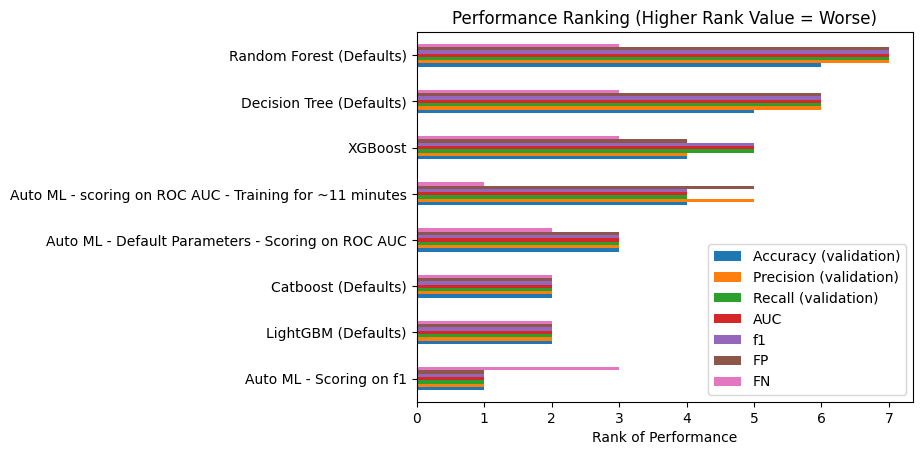

In [51]:
ranking_df.drop(columns="Rank Sum").plot(
    kind="barh",
    title="Performance Ranking (Higher Rank Value = Worse)",
    xlabel="Rank of Performance"
    )